In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import cross_val_score,  GridSearchCV
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor


file_path = "Speed_Camera_Violations_20250706.csv" 
df = pd.read_csv(file_path)
print(f"Filas originales: {len(df)}")
df.head()

C:\Users\brian\.conda\envs\Modelos_predictivos1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Filas originales: 431980


,ADDRESS,CAMERA ID,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,7739 S WESTERN,CHI064,01/11/2016,24,NaN,NaN,NaN,NaN,NaN
1,5520 S WESTERN,CHI069,02/10/2020,30,NaN,NaN,NaN,NaN,NaN
2,5520 S WESTERN,CHI069,07/31/2021,135,NaN,NaN,NaN,NaN,NaN
3,1111 N HUMBOLDT,CHI010,12/21/2015,36,NaN,NaN,NaN,NaN,NaN
4,5520 S WESTERN,CHI069,11/10/2022,76,NaN,NaN,NaN,NaN,NaN


In [2]:
!jupyter kernelspec list


Available kernels:
  python3    C:\Users\brian\.conda\envs\Modelos_predictivos1\share\jupyter\kernels\python3


In [3]:

df["VIOLATION DATE"] = pd.to_datetime(df["VIOLATION DATE"], errors="coerce")

# Eliminar registros con fechas no válidas o datos críticos faltantes
df = df.dropna(subset=["VIOLATION DATE", "CAMERA ID", "LATITUDE", "LONGITUDE", "VIOLATIONS"])

# Asegurar que VIOLATIONS sea numérica
df["VIOLATIONS"] = pd.to_numeric(df["VIOLATIONS"], errors="coerce")

# Eliminar valores negativos en VIOLATIONS
df = df[df["VIOLATIONS"] >= 0]

# Eliminar duplicados exactos
df = df.drop_duplicates()

print(f"Filas después de limpieza: {len(df)}")
print(f"Nulos por columna:\n{df.isnull().sum()}")



Filas después de limpieza: 416111
Nulos por columna:
ADDRESS           0
CAMERA ID         0
VIOLATION DATE    0
VIOLATIONS        0
X COORDINATE      0
Y COORDINATE      0
LATITUDE          0
LONGITUDE         0
LOCATION          0
dtype: int64


In [4]:
#Columnas temporales
df["YEAR"] = df["VIOLATION DATE"].dt.year
df["MONTH"] = df["VIOLATION DATE"].dt.month
df["DAY"] = df["VIOLATION DATE"].dt.day
df["WEEKDAY"] = df["VIOLATION DATE"].dt.day_name()

df[["VIOLATION DATE", "YEAR", "MONTH", "DAY", "WEEKDAY"]].head()


,VIOLATION DATE,YEAR,MONTH,DAY,WEEKDAY
3699,2018-10-20,2018,10,20,Saturday
3700,2015-12-09,2015,12,9,Wednesday
3701,2018-05-22,2018,5,22,Tuesday
3702,2014-10-14,2014,10,14,Tuesday
3703,2023-07-14,2023,7,14,Friday


C:\Users\brian\AppData\Local\Temp\ipykernel_28996\3979922432.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=violaciones_anuales, x="YEAR", y="VIOLATIONS", palette="viridis")


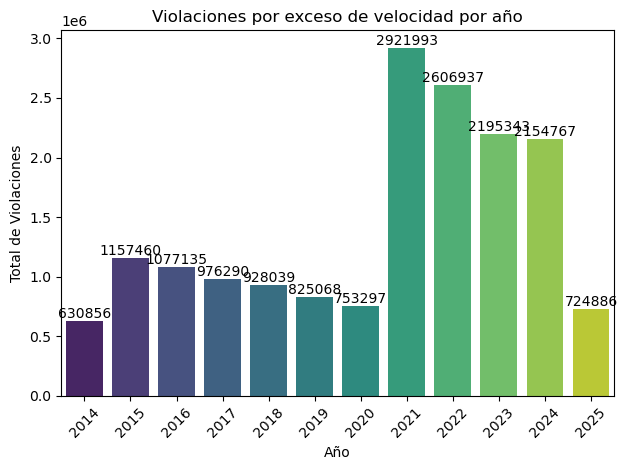

In [5]:
#Violaciones por año

violaciones_anuales = df.groupby("YEAR")["VIOLATIONS"].sum().reset_index()

sns.barplot(data=violaciones_anuales, x="YEAR", y="VIOLATIONS", palette="viridis")
plt.title("Violaciones por exceso de velocidad por año")
plt.xticks(rotation=45)
plt.xlabel("Año")
plt.ylabel("Total de Violaciones")

for index, row in violaciones_anuales.iterrows():
    plt.text(x=index, y=row["VIOLATIONS"], s=int(row["VIOLATIONS"]), ha='center', va='bottom')

plt.tight_layout()
plt.show()
#IDENTIFICAR PORQUE HAY SE VEN MAS VIOLACIONES POR EXCESO DE VELOCIDAD DESDE EL AÑO 2021...MAS CAMARAS?....
#Despues de bucar encontre esto: The City lowered the threshold for $35 citations issued by speed cameras 
#from 10 mph over the speed limit to 6-10 mph over the speed limit. 

C:\Users\brian\AppData\Local\Temp\ipykernel_28996\4294948957.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="pastel")


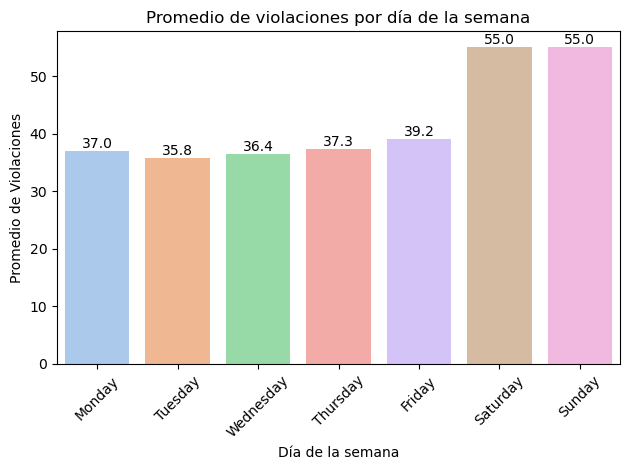

In [6]:
orden_dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_avg = df.groupby("WEEKDAY")["VIOLATIONS"].mean().reindex(orden_dias)

# Gráfica
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="pastel")
plt.title("Promedio de violaciones por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Promedio de Violaciones")
plt.xticks(rotation=45)

for i, val in enumerate(weekday_avg.values):
    plt.text(i, val, f"{val:.1f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

C:\Users\brian\AppData\Local\Temp\ipykernel_28996\434930818.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_camaras, x="CAMERA ID", y="VIOLATIONS", palette="mako")


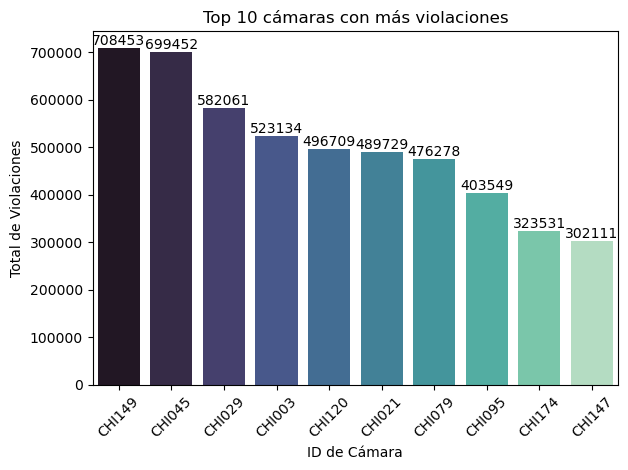

In [7]:
#Top 10 cámaras con más violaciones

top_camaras = df.groupby("CAMERA ID")["VIOLATIONS"].sum().nlargest(10).reset_index()

# Gráfica
sns.barplot(data=top_camaras, x="CAMERA ID", y="VIOLATIONS", palette="mako")
plt.title("Top 10 cámaras con más violaciones")
plt.xlabel("ID de Cámara")
plt.ylabel("Total de Violaciones")
plt.xticks(rotation=45)

for i, row in top_camaras.iterrows():
    plt.text(i, row["VIOLATIONS"], f"{int(row['VIOLATIONS'])}", ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

#PENDIENTE BUSCAR UBICACION DE ESTA CAMARA...

In [8]:
# Columnas a usar
columnas_temporales = ["YEAR", "MONTH", "DAY", "WEEKDAY"]
incluir_espacial = True  #Si/No coordenadas - Test

# Agregar columnas numéricas y categóricas
numericas = ["YEAR", "MONTH", "DAY"]
categóricas = ["WEEKDAY", "CAMERA ID"]
if incluir_espacial:
    numericas += ["LATITUDE", "LONGITUDE"]
columnas_X = numericas + categóricas



In [9]:
# Codificador para columnas categóricas
preprocesador = ColumnTransformer(transformers=[
    ("num", "passthrough", numericas),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categóricas)
])

modelo_lineal = Pipeline(steps=[
    ("preprocesamiento", preprocesador),
    ("modelo", LinearRegression())
])

modelo_rf = Pipeline(steps=[
    ("preprocesamiento", preprocesador),
    ("modelo", RandomForestRegressor(n_estimators=10, random_state=42))
])


In [10]:
#Dataset
X = df[columnas_X].copy()
filas_antes = len(X)
X = X.dropna()
print(f"Filas eliminadas por nulos: {filas_antes - len(X)}")
y = df.loc[X.index, "VIOLATIONS"]

# ====================================
# Validación cruzada
# ====================================
cv_mae_scores = -cross_val_score(modelo_rf, X, y, cv=3, scoring='neg_mean_absolute_error')
cv_rmse_scores = -cross_val_score(modelo_rf, X, y, cv=3, scoring='neg_root_mean_squared_error')
cv_r2_scores = cross_val_score(modelo_rf, X, y, cv=3, scoring='r2')

print("\n Validación Cruzada (3-Fold) - Random Forest:")
print(f"MAE promedio:  {cv_mae_scores.mean():.2f} ± {cv_mae_scores.std():.2f}")
print(f"RMSE promedio: {cv_rmse_scores.mean():.2f} ± {cv_rmse_scores.std():.2f}")
print(f"R² promedio:   {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")


Filas eliminadas por nulos: 0

 Validación Cruzada (3-Fold) - Random Forest:
MAE promedio:  9.12 ± 0.02
RMSE promedio: 16.68 ± 0.06
R² promedio:   0.9088 ± 0.0006


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train: {len(X_train)} filas, Test: {len(X_test)} filas")

Train: 332888 filas, Test: 83223 filas


In [12]:
param_grid = {
    'modelo__n_estimators': [50, 100, 150],
    'modelo__max_depth': [10, None],
    'modelo__min_samples_split': [2],
    'modelo__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(modelo_rf, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=4, verbose=2)

grid_search.fit(X, y)
print("\n Mejores parámetros encontrados:")
print(grid_search.best_params_)

# ====================================
#Evaluación del modelo final
# ====================================
mejor_modelo = grid_search.best_estimator_
mejor_modelo.fit(X_train, y_train)
y_pred = mejor_modelo.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Resultados del modelo final optimizado:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

 Mejores parámetros encontrados:
{'modelo__max_depth': None, 'modelo__min_samples_leaf': 2, 'modelo__min_samples_split': 2, 'modelo__n_estimators': 150}

 Resultados del modelo final optimizado:
MAE:  8.48
RMSE: 15.30
R²:   0.9246


In [13]:
# Función para MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = np.finfo(float).eps  
    return np.mean(np.abs((y_true - y_pred) / np.maximum(epsilon, np.abs(y_true)))) * 100

# Calcular MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

# Función para SMAPE
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Evitar división por cero con un pequeño valor
    denominator = np.where(denominator == 0, np.finfo(float).eps, denominator)
    return np.mean(np.abs(y_pred - y_true) / denominator) * 100

# Calcular SMAPE
smape_score = smape(y_test, y_pred)
print(f"SMAPE: {smape_score:.2f}%")


MAPE: 45.71%
SMAPE: 30.56%


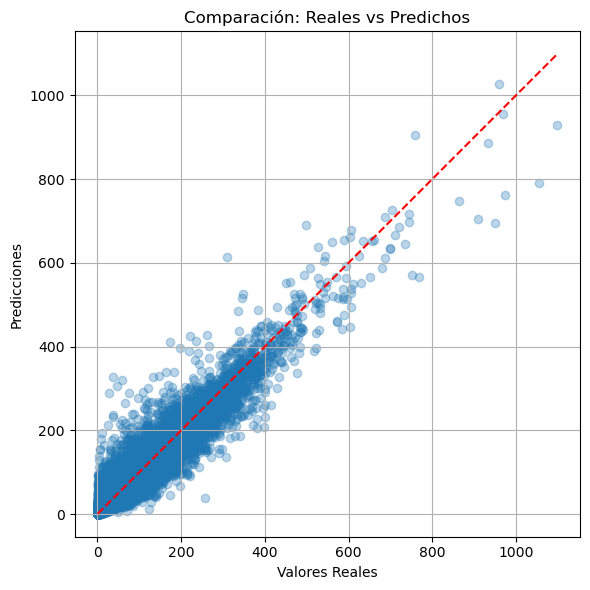

In [14]:
#Gráfico Reales vs Predichos

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparación: Reales vs Predichos")
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\brian\AppData\Local\Temp\ipykernel_28996\2378070675.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_importancias, x="Importancia", y="Variable", palette="rocket")


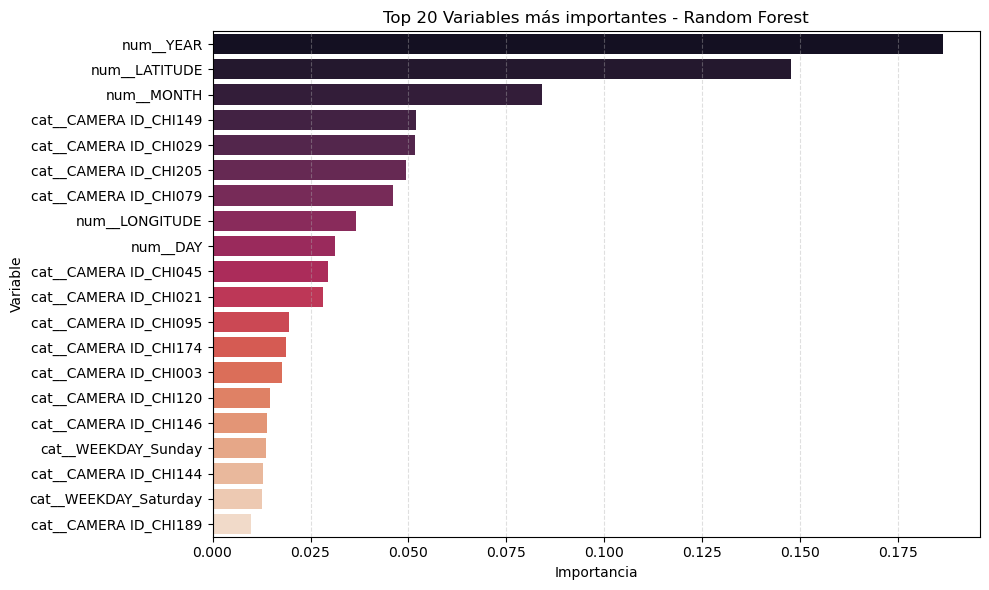

In [15]:
#Importancia de Variables (Top 20)

importancias = mejor_modelo.named_steps["modelo"].feature_importances_
nombres_columnas = mejor_modelo.named_steps["preprocesamiento"].get_feature_names_out()

# Crear DataFrame de importancias
df_importancias = pd.DataFrame({
    "Variable": nombres_columnas,
    "Importancia": importancias
}).sort_values(by="Importancia", ascending=False)

# Tomar solo las 20 más importantes
top_importancias = df_importancias.head(20)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=top_importancias, x="Importancia", y="Variable", palette="rocket")
plt.title("Top 20 Variables más importantes - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Holt-Winters (Modo inicial):
MAE: 4420.17, RMSE: 5092.36
Holt-Winters MAPE:  0.79%
Holt-Winters SMAPE: 118.15%


C:\Users\brian\.conda\envs\Modelos_predictivos1\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


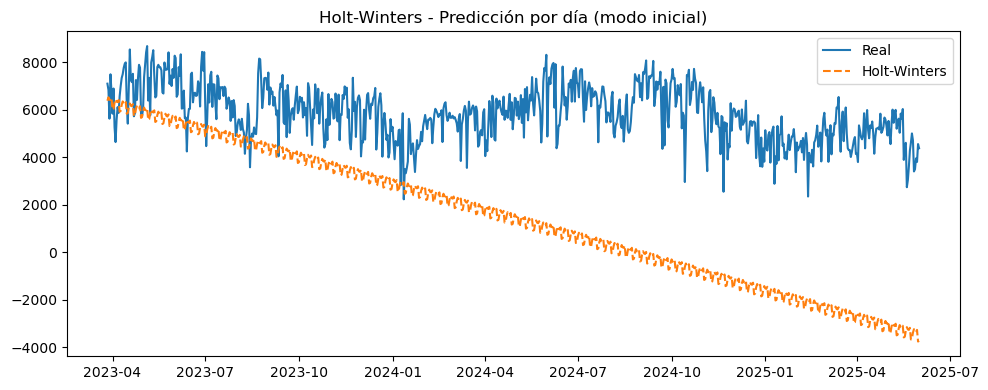

In [31]:
# Holt-Winters por día
# Filtro desde 2021 en adelante

# 1. Agrupar por día sin filtrar por año
df_diario = df.groupby("VIOLATION DATE")["VIOLATIONS"].sum().asfreq("D").fillna(0)

# 2. División entrenamiento / prueba
train_size = int(len(df_diario) * 0.8)
train_hw, test_hw = df_diario[:train_size], df_diario[train_size:]

# 3. Modelo básico Holt-Winters (modo inicial)
modelo_hw = ExponentialSmoothing(
    train_hw,
    trend='add',
    seasonal='add',
    seasonal_periods=7  # semanal
).fit()

# 4. Predicción
pred_hw = modelo_hw.forecast(len(test_hw))

# 5. Evaluación
mae_hw = mean_absolute_error(test_hw, pred_hw)
rmse_hw = np.sqrt(mean_squared_error(test_hw, pred_hw))
mape_hw = mean_absolute_percentage_error(test_hw.values, pred_hw.values)

# Función SMAPE (si no la tienes)
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_hw = smape(test_hw.values, pred_hw.values)

# 6. Resultados
print("Holt-Winters (Modo inicial):")
print(f"MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}")
print(f"Holt-Winters MAPE:  {mape_hw:.2f}%")
print(f"Holt-Winters SMAPE: {smape_hw:.2f}%")

# 7. Gráfica
plt.figure(figsize=(10,4))
plt.plot(test_hw.index, test_hw, label="Real")
plt.plot(test_hw.index, pred_hw, label="Holt-Winters", linestyle="--")
plt.title("Holt-Winters - Predicción por día (modo inicial)")
plt.legend()
plt.tight_layout()
plt.show()



C:\Users\brian\.conda\envs\Modelos_predictivos1\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\brian\.conda\envs\Modelos_predictivos1\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Holt-Winters (multiplicativo, estacionalidad mensual):
MAE: 4211.91, RMSE: 4455.95
MAPE: 0.80%
SMAPE: 145.28%


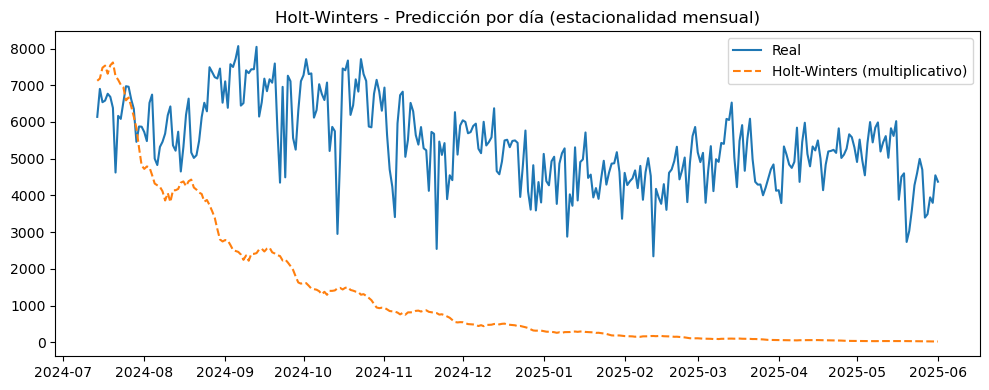

In [32]:
# 1. Filtro desde 2021
df_filtrado = df[df["VIOLATION DATE"] >= "2021-01-01"]
df_diario = df_filtrado.groupby("VIOLATION DATE")["VIOLATIONS"].sum().asfreq("D").fillna(0)

# 2. División entrenamiento / prueba
train_size = int(len(df_diario) * 0.8)
train_hw, test_hw = df_diario[:train_size], df_diario[train_size:]

# 3. Modelo Holt-Winters con ajustes nuevos
modelo_hw = ExponentialSmoothing(
    train_hw,
    trend='multiplicative',
    seasonal='multiplicative',
    seasonal_periods=30  # ciclos mensuales aproximados
).fit(optimized=True, use_brute=True)

# 4. Predicción
pred_hw = modelo_hw.forecast(len(test_hw))

# 5. Evaluación
mae_hw = mean_absolute_error(test_hw, pred_hw)
rmse_hw = np.sqrt(mean_squared_error(test_hw, pred_hw))
mape_hw = mean_absolute_percentage_error(test_hw.values, pred_hw.values)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

smape_hw = smape(test_hw.values, pred_hw.values)

# 6. Resultados
print("Holt-Winters (multiplicativo, estacionalidad mensual):")
print(f"MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}")
print(f"MAPE: {mape_hw:.2f}%")
print(f"SMAPE: {smape_hw:.2f}%")

# 7. Gráfica
plt.figure(figsize=(10,4))
plt.plot(test_hw.index, test_hw, label="Real")
plt.plot(test_hw.index, pred_hw, label="Holt-Winters (multiplicativo)", linestyle="--")
plt.title("Holt-Winters - Predicción por día (estacionalidad mensual)")
plt.legend()
plt.tight_layout()
plt.show()


 Holt-Winters semanal:
MAE: 18412.61, RMSE: 22841.69
MAPE: 0.53%
SMAPE: 37.76%


C:\Users\brian\.conda\envs\Modelos_predictivos1\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


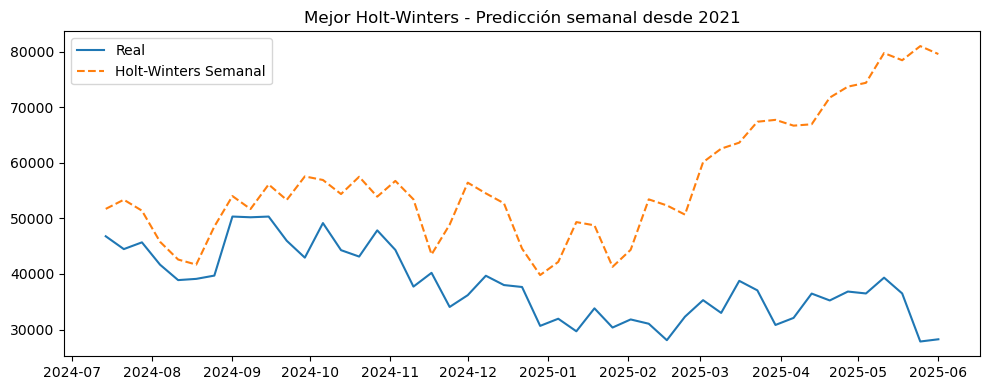

In [35]:

# Agrupar semanalmente desde 2021
df_semanal = (
    df[df["VIOLATION DATE"] >= "2021-01-01"]
    .groupby("VIOLATION DATE")["VIOLATIONS"]
    .sum()
    .resample("W")
    .sum()
    .fillna(0)
)

# División entrenamiento / prueba
train_size = int(len(df_semanal) * 0.8)
train_hw, test_hw = df_semanal[:train_size], df_semanal[train_size:]

# Mejor modelo Holt-Winters
modelo_hw = ExponentialSmoothing(
    train_hw,
    trend='add',
    seasonal='add',
    seasonal_periods=52  # 1 año de semanas
).fit(optimized=True, use_brute=True)

# Predicción
pred_hw = modelo_hw.forecast(len(test_hw))

# Evaluación
mae_hw = mean_absolute_error(test_hw, pred_hw)
rmse_hw = np.sqrt(mean_squared_error(test_hw, pred_hw))
mape_hw = mean_absolute_percentage_error(test_hw.values, pred_hw.values)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

smape_hw = smape(test_hw.values, pred_hw.values)

# Resultados
print(" Holt-Winters semanal:")
print(f"MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}")
print(f"MAPE: {mape_hw:.2f}%")
print(f"SMAPE: {smape_hw:.2f}%")

# Gráfica
plt.figure(figsize=(10,4))
plt.plot(test_hw.index, test_hw, label="Real")
plt.plot(test_hw.index, pred_hw, label="Holt-Winters Semanal", linestyle="--")
plt.title("Mejor Holt-Winters - Predicción semanal desde 2021")
plt.legend()
plt.tight_layout()
plt.show()


01:54:17 - cmdstanpy - INFO - Chain [1] start processing
01:54:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet:
MAE: 1184.90, RMSE: 1406.01
Prophet MAPE:  27.33%
Prophet SMAPE: 22.42%


C:\Users\brian\.conda\envs\Modelos_predictivos1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\brian\.conda\envs\Modelos_predictivos1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


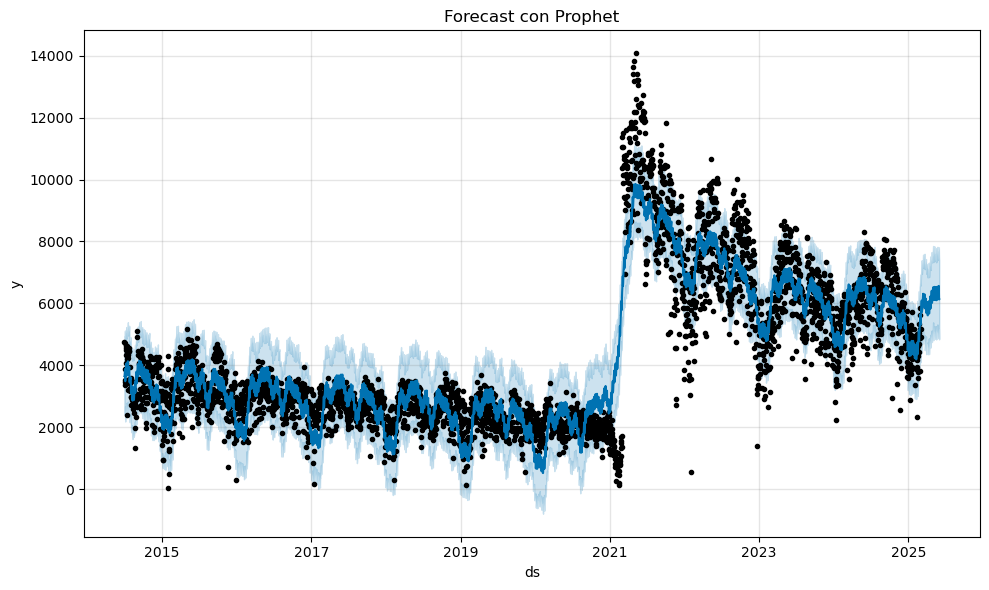

In [19]:
# Preparar datos para Prophet
df_prophet = df.groupby("VIOLATION DATE")["VIOLATIONS"].sum().reset_index()
df_prophet.columns = ["ds", "y"]

train_p = df_prophet.iloc[:-90]
test_p = df_prophet.iloc[-90:]

modelo_prophet = Prophet()
modelo_prophet.fit(train_p)
future = modelo_prophet.make_future_dataframe(periods=90)
forecast = modelo_prophet.predict(future)

# Evaluación
pred_p = forecast.set_index("ds").loc[test_p["ds"], "yhat"]
mae_p = mean_absolute_error(test_p["y"], pred_p)
rmse_p = np.sqrt(mean_squared_error(test_p["y"], pred_p))
print("Prophet:")
print(f"MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}")

df_merged = pd.merge(test_p, forecast[["ds", "yhat"]], on="ds", how="inner")

# MAPE para Prophet
y_true_prophet = df_merged['y']
y_pred_prophet = df_merged['yhat']

mape_prophet = mean_absolute_percentage_error(y_true_prophet, y_pred_prophet)
smape_prophet = smape(y_true_prophet, y_pred_prophet)

print(f"Prophet MAPE:  {mape_prophet:.2f}%")
print(f"Prophet SMAPE: {smape_prophet:.2f}%")


modelo_prophet.plot(forecast)
plt.title("Forecast con Prophet")
plt.tight_layout()
plt.show()

02:14:48 - cmdstanpy - INFO - Chain [1] start processing
02:14:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\brian\.conda\envs\Modelos_predictivos1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\brian\.conda\envs\Modelos_predictivos1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Prophet (Semanal):
MAE: 11139.59, RMSE: 12345.59
MAPE: 0.34%
SMAPE: 27.89%


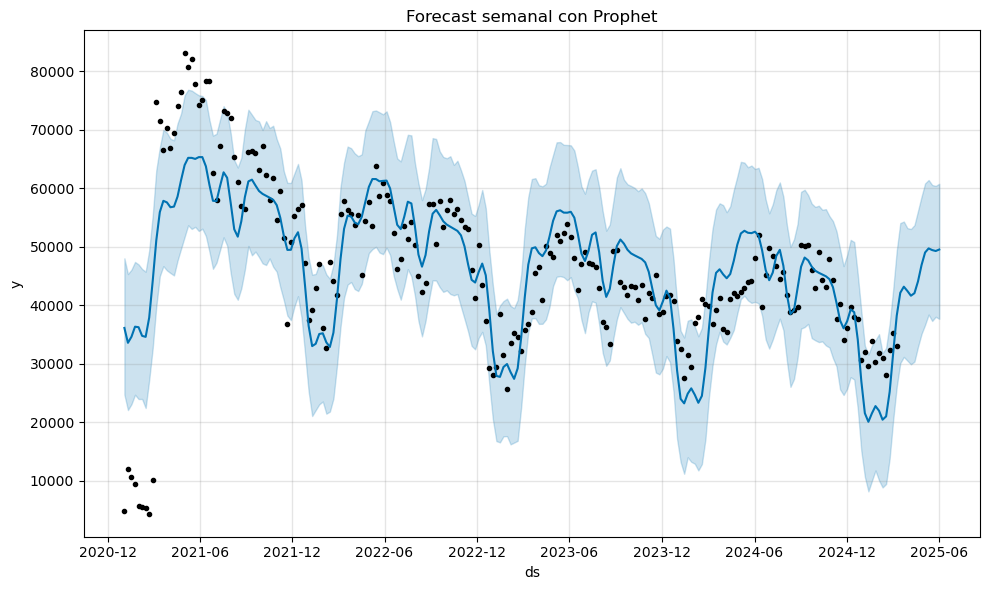

In [28]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# 1. Filtro y agrupación semanal
df_semanal = (
    df[df["VIOLATION DATE"] >= "2021-01-01"]
    .groupby("VIOLATION DATE")["VIOLATIONS"]
    .sum()
    .resample("W")  # Agrupación por semana
    .sum()
    .reset_index()
)

df_semanal.columns = ["ds", "y"]  # Prophet requiere columnas ds (fecha) e y (valor)

# 2. División entrenamiento / prueba
train_p = df_semanal.iloc[:-12]  # Usamos últimas 12 semanas como prueba (~3 meses)
test_p = df_semanal.iloc[-12:]

# 3. Modelo Prophet
modelo_prophet = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=True)
modelo_prophet.fit(train_p)

# 4. Forecast
future = modelo_prophet.make_future_dataframe(periods=12, freq='W')
forecast = modelo_prophet.predict(future)

# 5. Evaluación
# Combinar predicciones con datos reales
df_merged = pd.merge(test_p, forecast[["ds", "yhat"]], on="ds", how="inner")
y_true = df_merged["y"]
y_pred = df_merged["yhat"]

mae_p = mean_absolute_error(y_true, y_pred)
rmse_p = np.sqrt(mean_squared_error(y_true, y_pred))
mape_p = mean_absolute_percentage_error(y_true, y_pred)

# Función SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

smape_p = smape(y_true, y_pred)

# 6. Resultados
print("Prophet (Semanal):")
print(f"MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}")
print(f"MAPE: {mape_p:.2f}%")
print(f"SMAPE: {smape_p:.2f}%")

# 7. Gráfica
modelo_prophet.plot(forecast)
plt.title("Forecast semanal con Prophet")
plt.tight_layout()
plt.show()


XGBoost:
MAE: 20.61, RMSE: 30.87, R²: 0.6930
XGBoost MAPE:  231.71%
XGBoost SMAPE: 68.05%


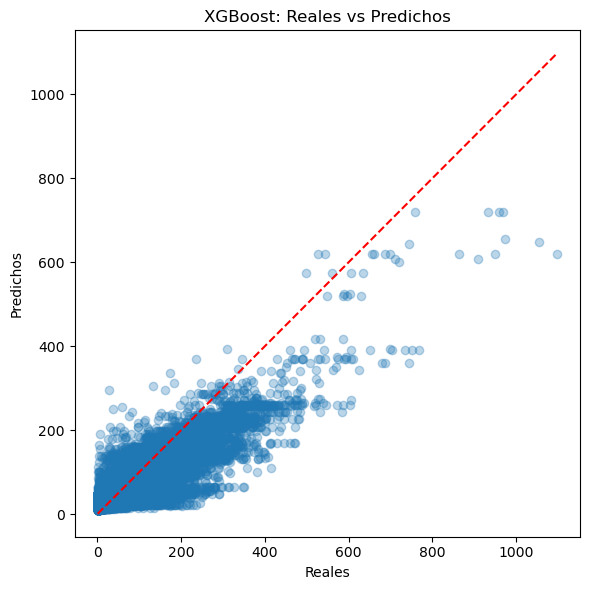

In [20]:
# Preprocesador
preprocesador = ColumnTransformer(transformers=[
    ("num", "passthrough", numericas),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categóricas)
])

modelo_xgb = Pipeline(steps=[
    ("preprocesamiento", preprocesador),
    ("modelo", XGBRegressor(n_estimators=10, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_xgb.fit(X_train, y_train)
y_pred_xgb = modelo_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost:")
print(f"MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.4f}")

mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
smape_xgb = smape(y_test, y_pred_xgb)

print(f"XGBoost MAPE:  {mape_xgb:.2f}%")
print(f"XGBoost SMAPE: {smape_xgb:.2f}%")


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Reales")
plt.ylabel("Predichos")
plt.title("XGBoost: Reales vs Predichos")
plt.tight_layout()
plt.show()

XGBoost (Semanal):
MAE: 4931.70, RMSE: 6989.34
MAPE: 0.16%
SMAPE: 13.52%


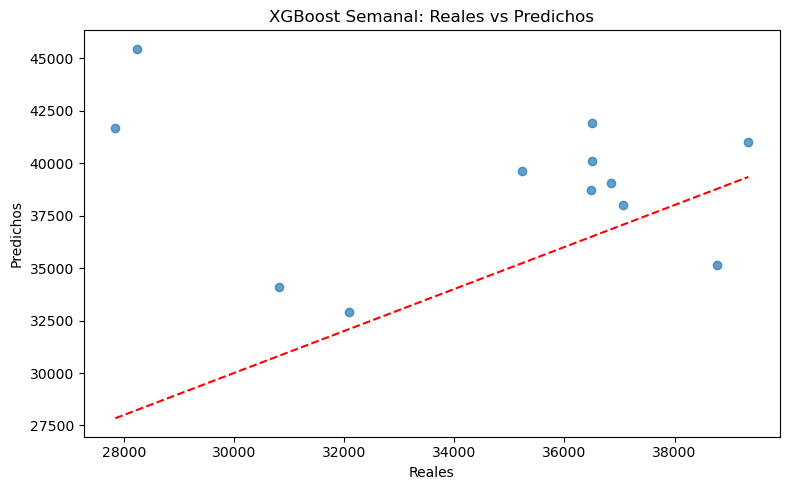

In [29]:
# 1. Filtro y agrupación semanal
df_semanal = (
    df[df["VIOLATION DATE"] >= "2021-01-01"]
    .groupby("VIOLATION DATE")["VIOLATIONS"]
    .sum()
    .resample("W")
    .sum()
    .reset_index()
)
df_semanal.columns = ["ds", "y"]

# 2. Crear variables temporales como features
df_semanal["week"] = df_semanal["ds"].dt.isocalendar().week.astype(int)
df_semanal["month"] = df_semanal["ds"].dt.month
df_semanal["year"] = df_semanal["ds"].dt.year
df_semanal["quarter"] = df_semanal["ds"].dt.quarter

# 3. Separar variables X e y
X = df_semanal[["week", "month", "year", "quarter"]]
y = df_semanal["y"]

# 4. Dividir en entrenamiento y prueba (últimas 12 semanas como test)
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

# 5. Modelo XGBoost
modelo_xgb = XGBRegressor(n_estimators=100, random_state=42)
modelo_xgb.fit(X_train, y_train)

# 6. Predicción
y_pred = modelo_xgb.predict(X_test)

# 7. Evaluación
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

smape_xgb = smape(y_test, y_pred)

# 8. Resultados
print("XGBoost (Semanal):")
print(f"MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"SMAPE: {smape_xgb:.2f}%")

# 9. Visualización
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Reales")
plt.ylabel("Predichos")
plt.title("XGBoost Semanal: Reales vs Predichos")
plt.tight_layout()
plt.show()